In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py


In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

# Problem 1
1)

Histogram of 4 features


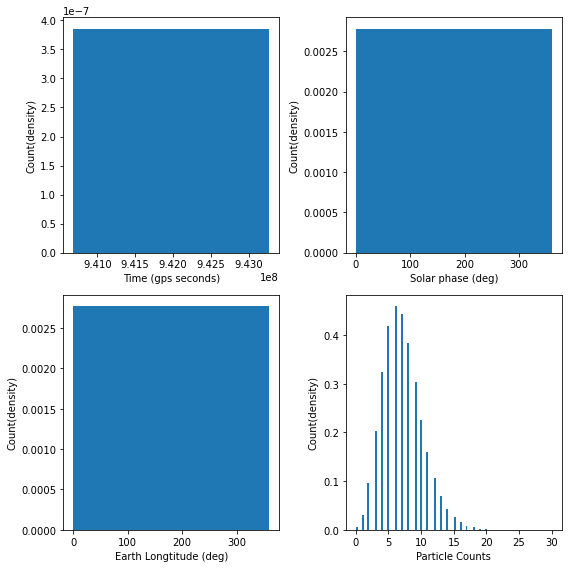

In [19]:
plt.rcParams["figure.figsize"] = (8,8)
print("Histogram of 4 features")
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2,i%2].hist(data[i,:],100,density=True)
    ax[i//2,i%2].set_ylabel("Count(density)")
ax[0,0].set_xlabel("Time (gps seconds)")
ax[0,1].set_xlabel("Solar phase (deg)")
ax[1,0].set_xlabel("Earth Longtitude (deg)")
ax[1,1].set_xlabel("Particle Counts")

plt.tight_layout()
plt.show()

From the histograms, we can see that the first three features - time, solar phase, earth longitude, are uniformly distributed, and particle counts is Poisson-like distributed. To verify whether the particle counts is Poisson distributed, we compare it with Poisson(mu=6).

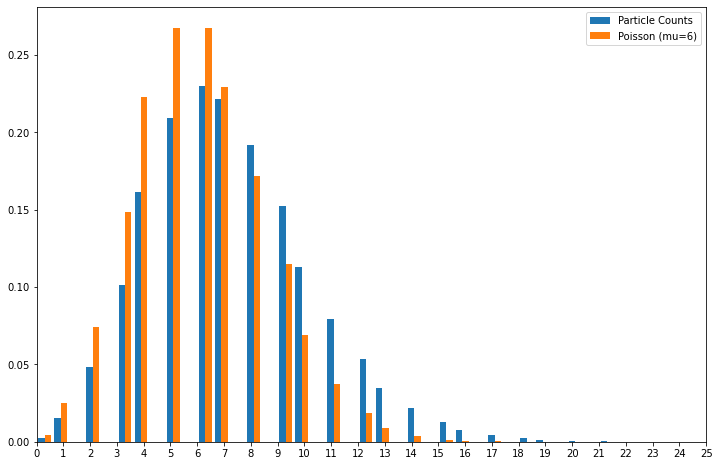

In [46]:
fig, ax = plt.subplots(1,1)
p_dis = stats.poisson.rvs(mu=6, loc=0, size=data.shape[1], random_state=None)
ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
ax.set_xlim([0,25])
ax.set_xticks(np.arange(0,26,1))
ax.legend(['Particle Counts','Poisson (mu=6)'])
plt.show()

Comparing to the Poisson, the distribution of Pariticle Counts has some difference, so there must be contamination.

Histogram of the first 3 features, weighted by Particle counts


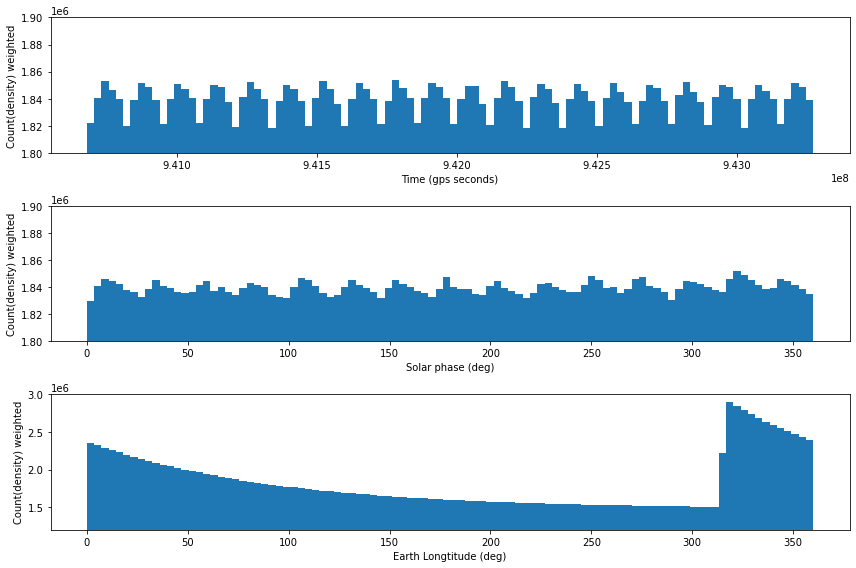

In [21]:
print("Histogram of the first 3 features, weighted by Particle counts")
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(3, 1)
for i in range(3):
    ax[i].hist(data[i,:],100,weights=data[3,:])
    ax[i].set_ylabel("Count(density) weighted")
ax[0].set_xlabel("Time (gps seconds)")
ax[0].set_ylim([1.8e6,1.9e6])
ax[1].set_xlabel("Solar phase (deg)")
ax[1].set_ylim([1.8e6,1.9e6])
ax[2].set_xlabel("Earth Longtitude (deg)")
ax[2].set_ylim([1.2e6,3e6])

plt.tight_layout()
plt.show()

The plots above show how particle counts varies by the first 3 features. All of them are showing periodic changes. The period of Time and Solar Phase are the same, but Earth Longitude has aparently greater period. I speculate that the data contamination described above originated from this.

In [96]:
def _split (data,minmax):
    if (minmax[0]<minmax[1]):
        return data[:,(data[2]>=minmax[0])&(data[2]<minmax[1])]
    return np.concatenate([data[:,(data[2]>=minmax[0])],data[:,(data[2]<minmax[1])]],axis=1)
def comp_p (data,minmax):
    data = _split(data,minmax)
    d_mean = np.mean(data[3,:])
    fig, ax = plt.subplots(1,1)
    p_dis = stats.poisson.rvs(mu=d_mean, loc=0, size=data.shape[1], random_state=None)
    ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
    ax.set_xlim([0,25])
    ax.set_xticks(np.arange(0,26,1))
    ax.set_title(str(minmax)+", mean=%.3f"%d_mean)
    ax.legend(['Particle Counts','Poisson (mu=%.3f)'%d_mean])
    return ax, d_mean

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


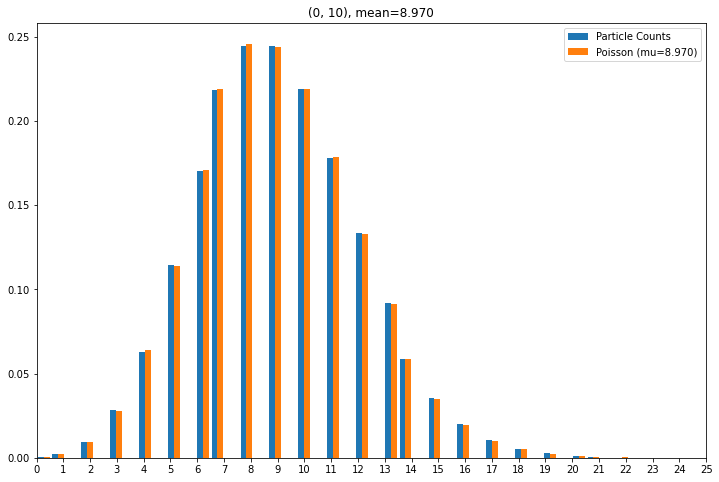

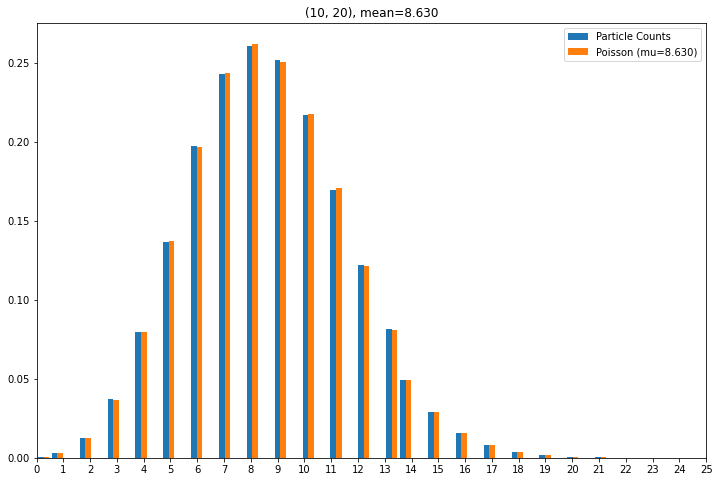

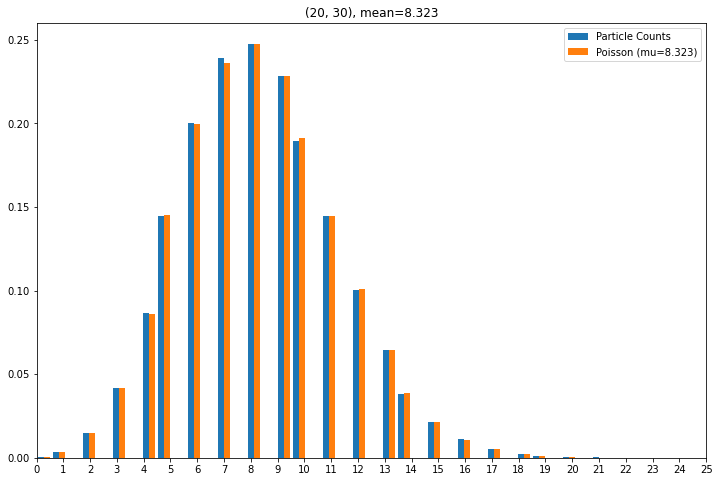

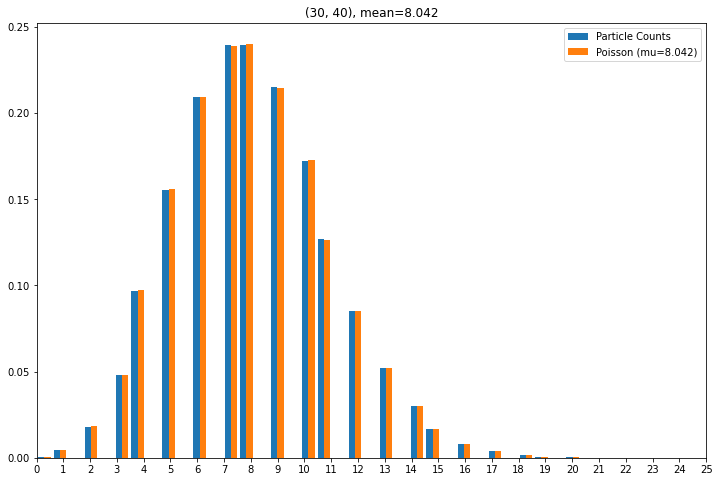

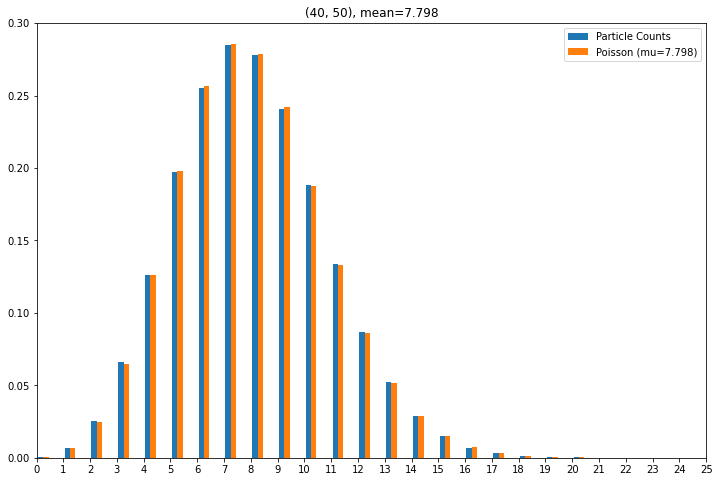

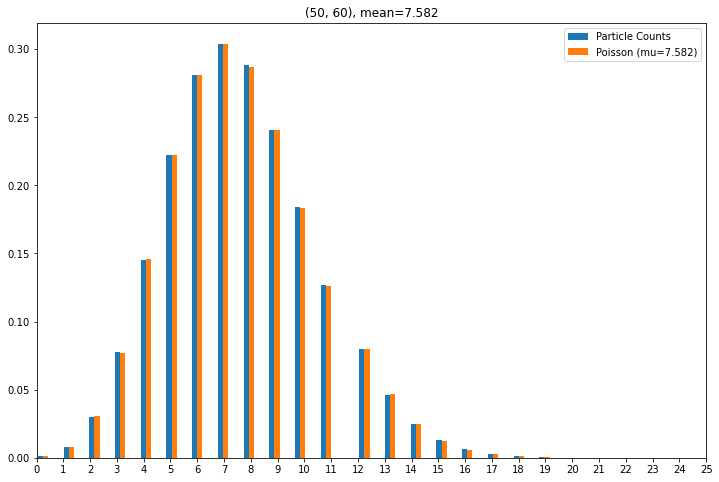

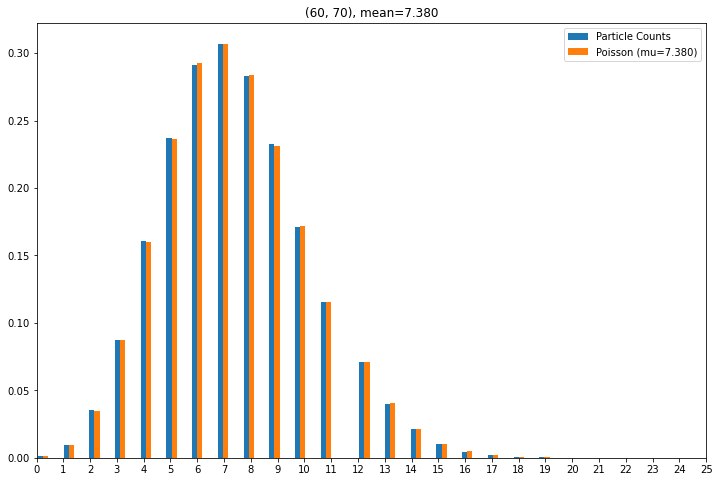

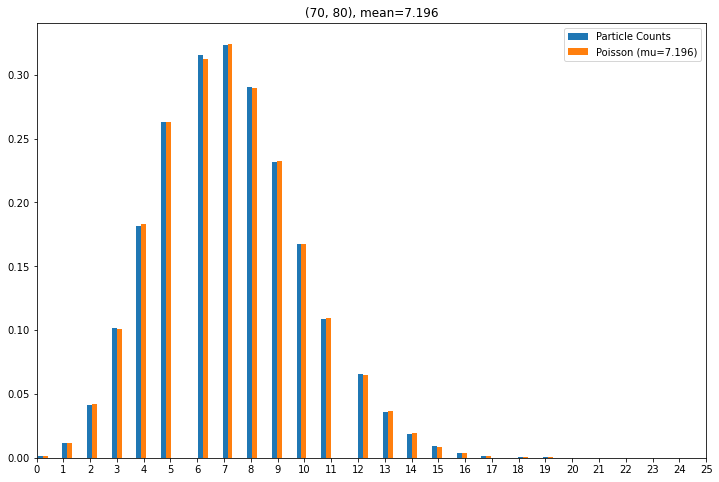

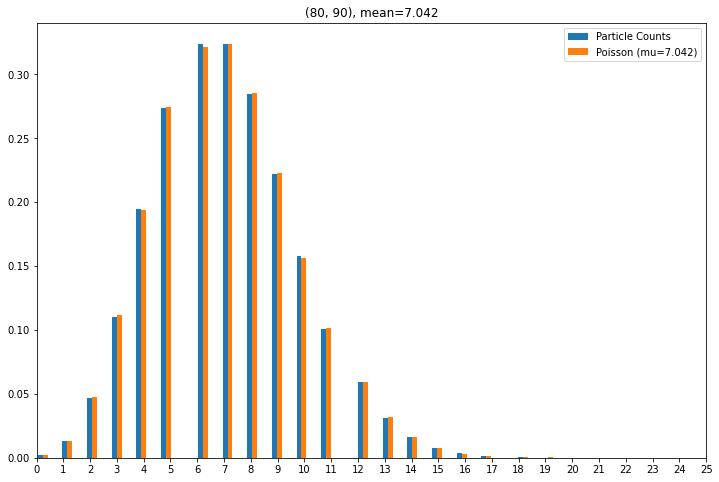

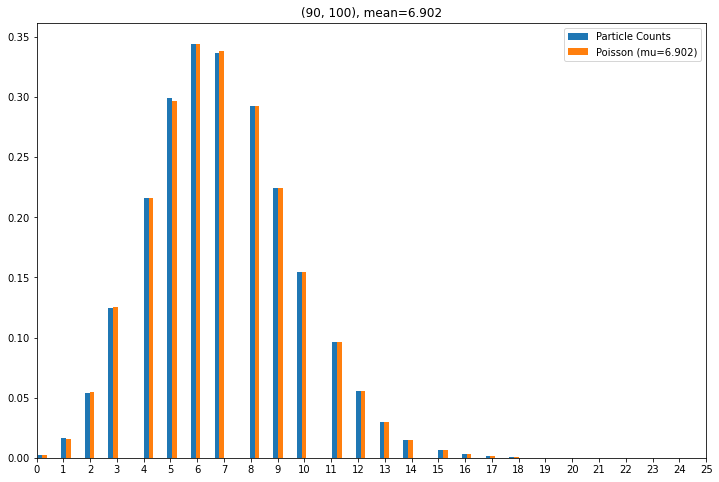

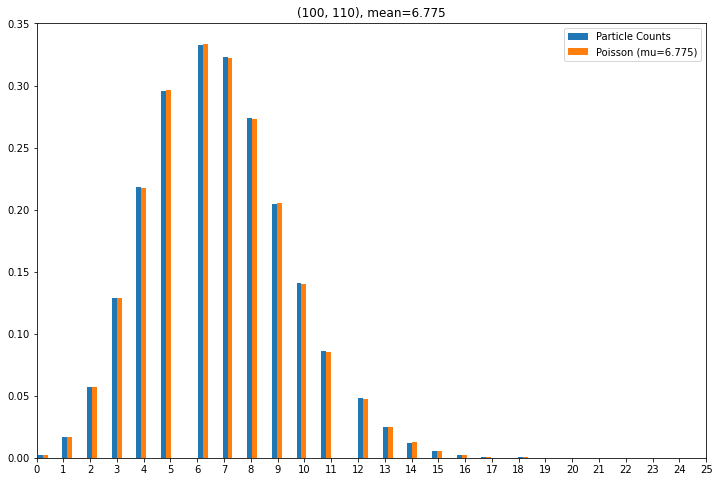

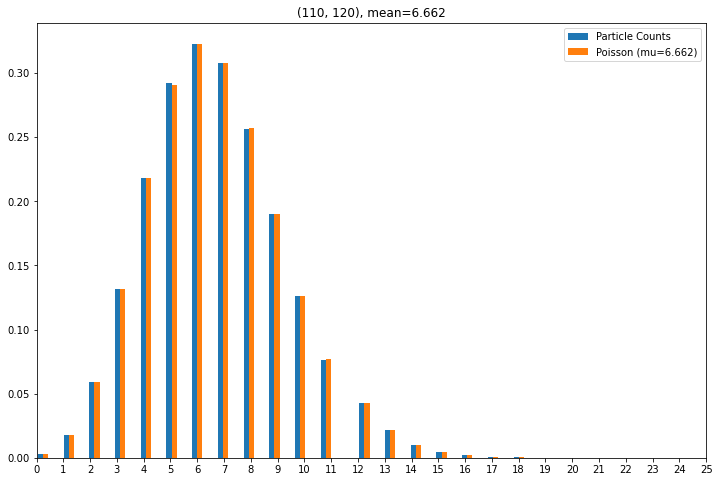

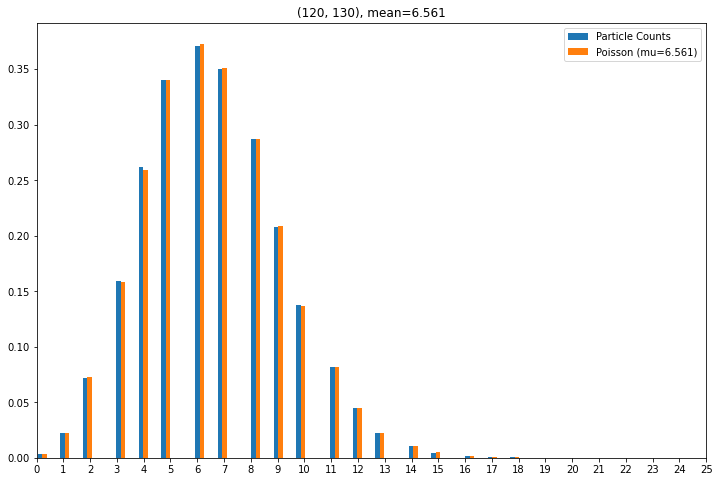

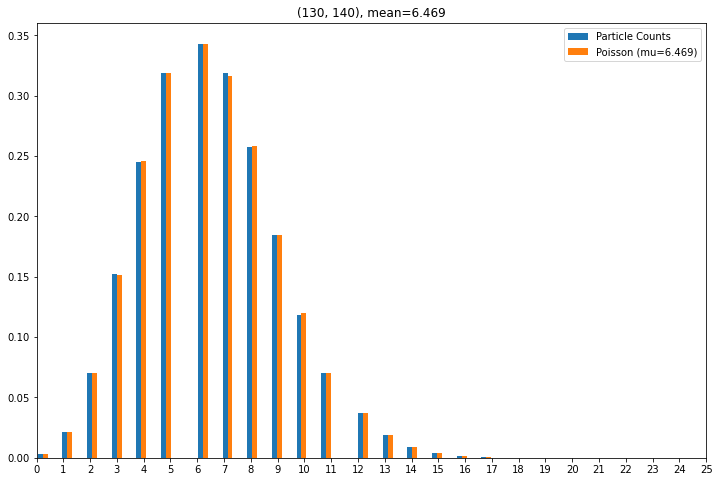

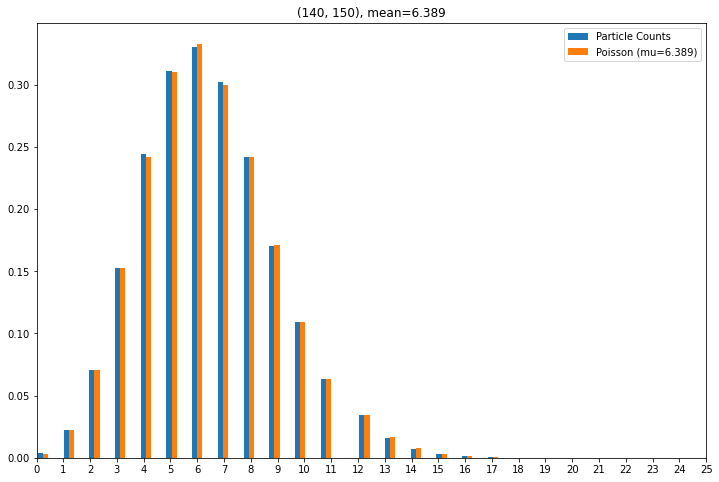

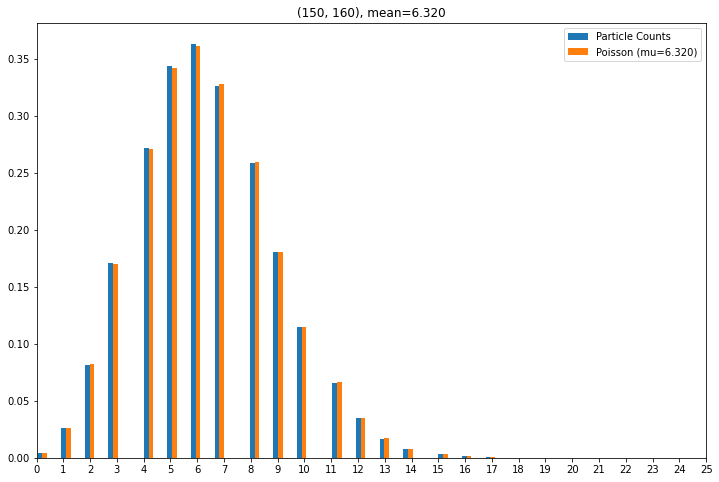

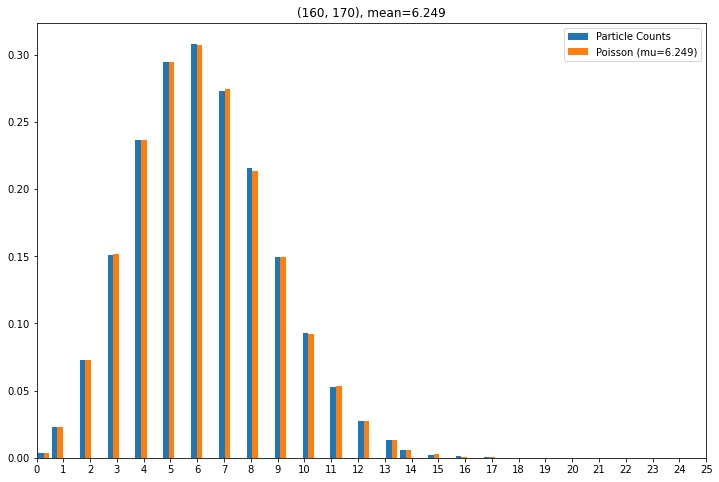

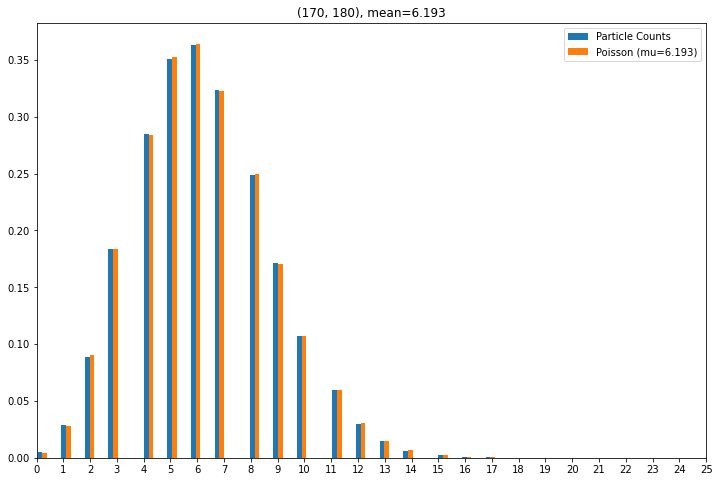

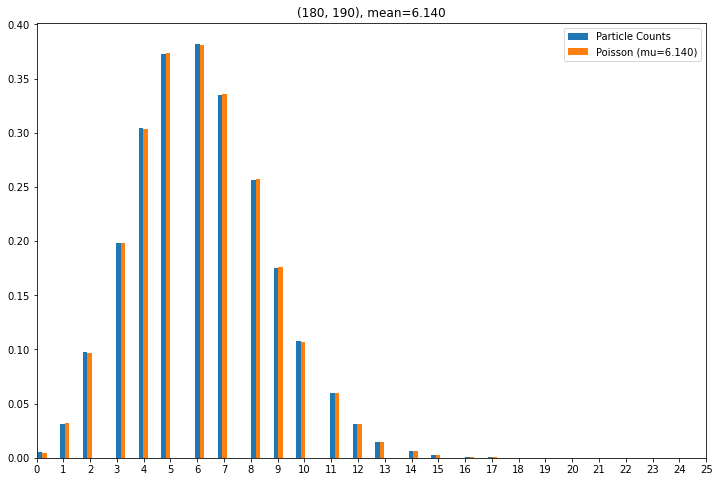

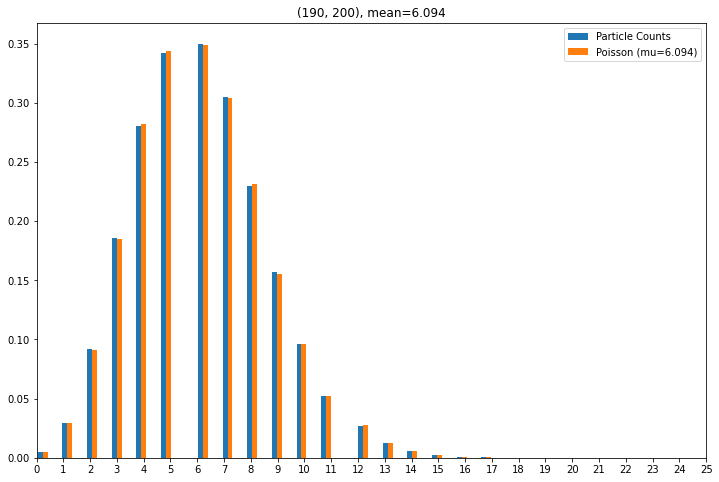

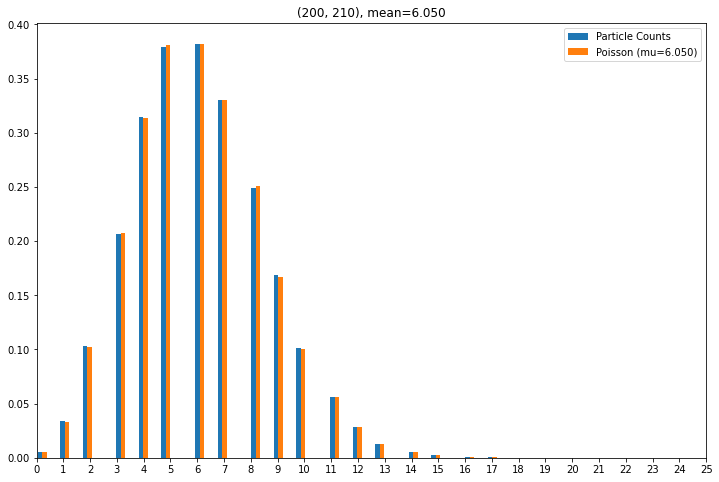

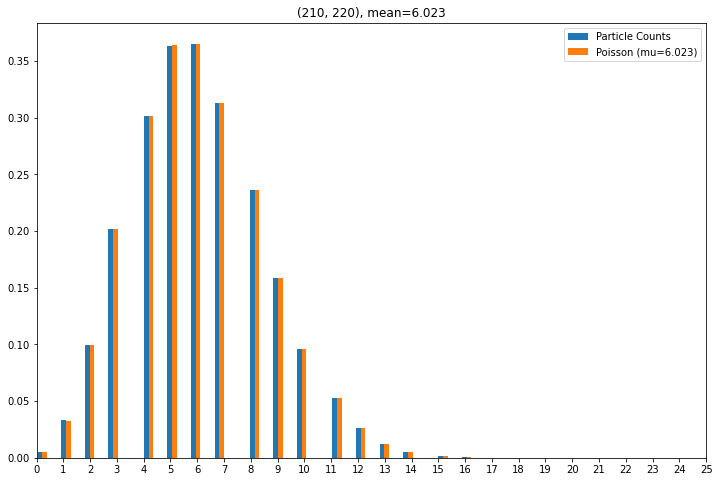

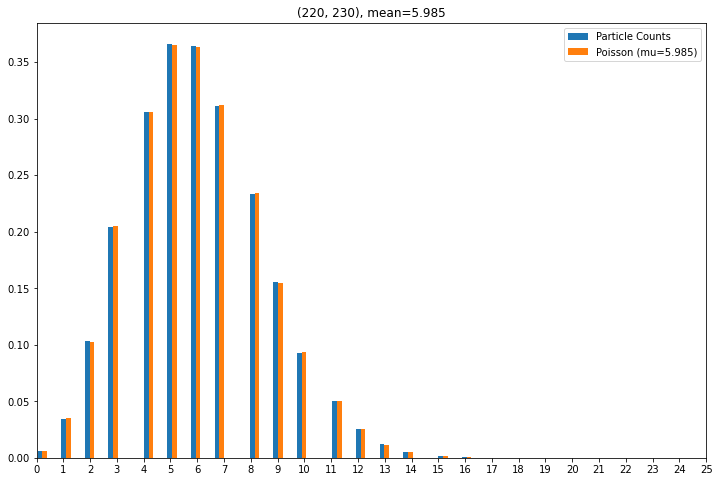

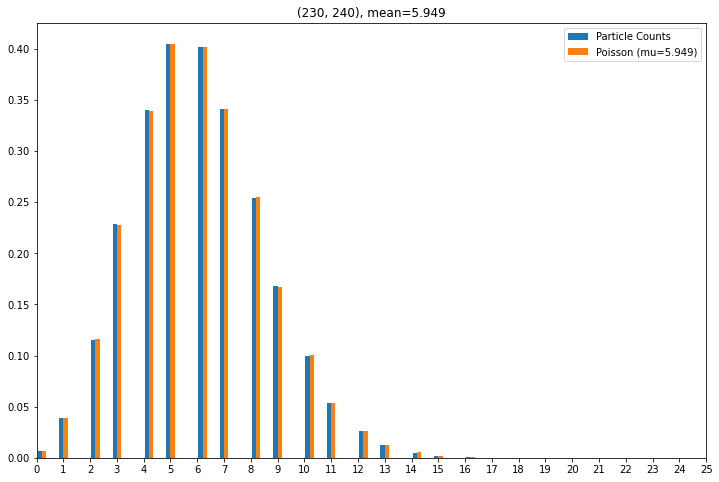

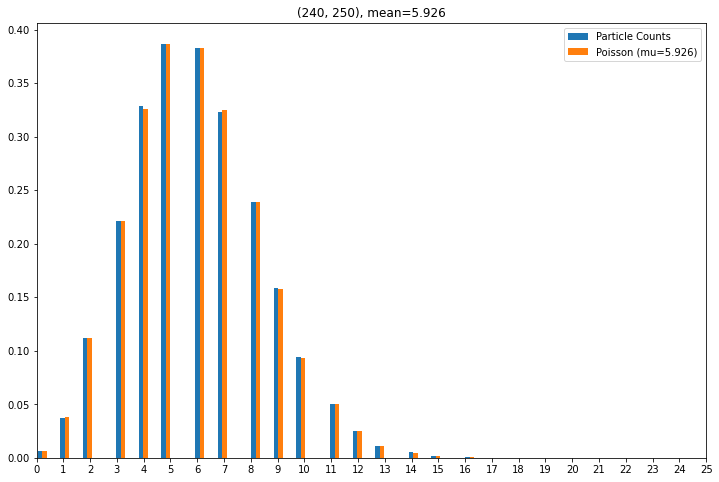

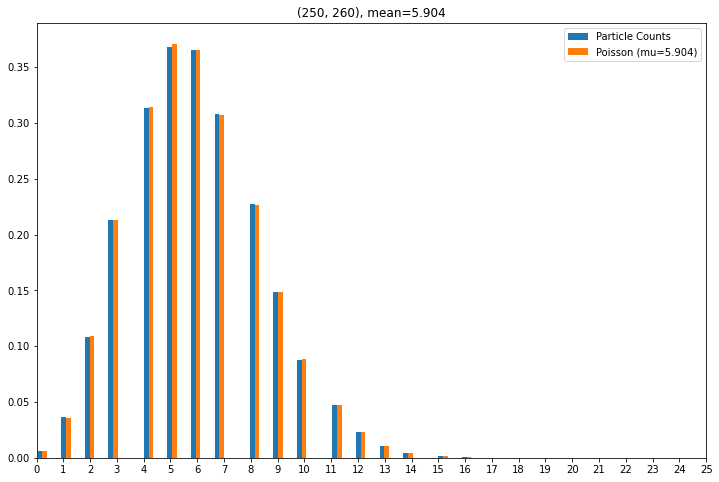

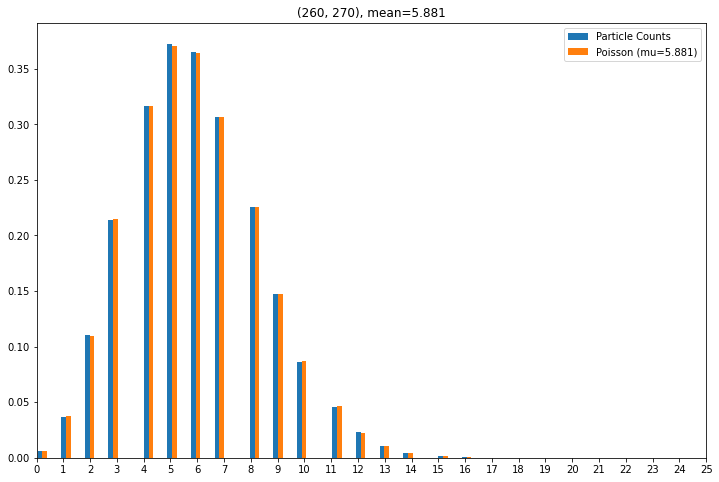

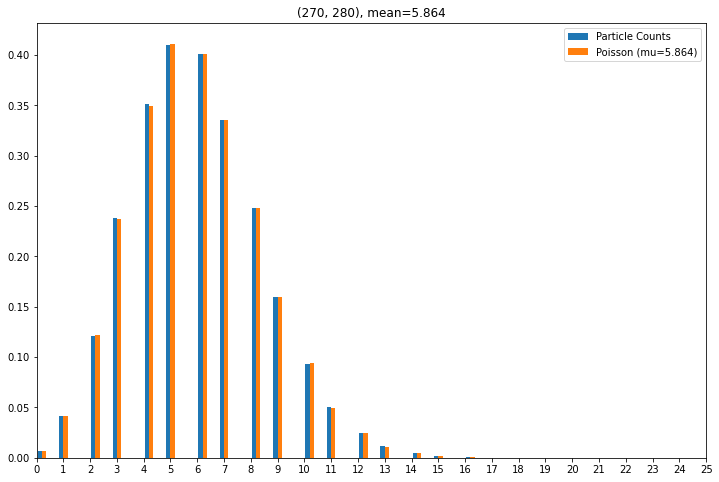

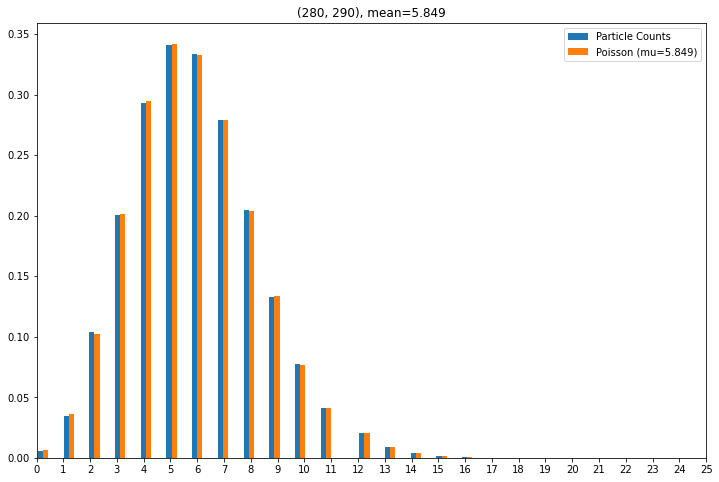

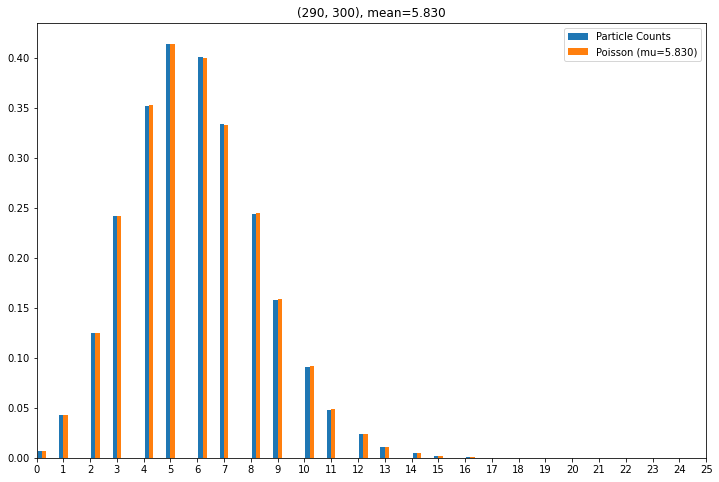

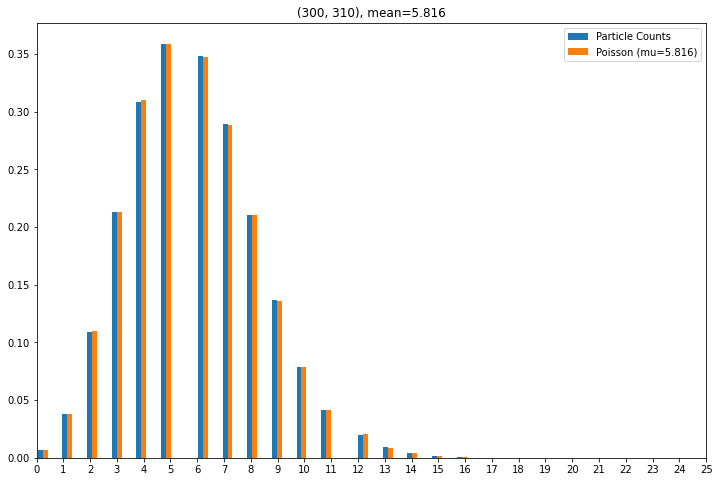

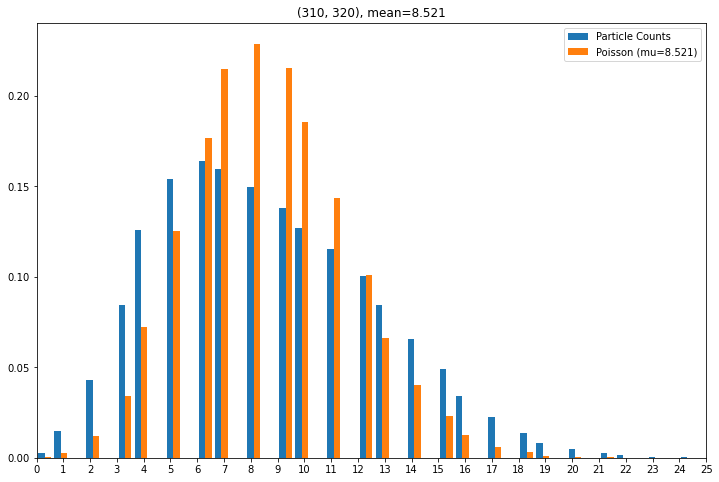

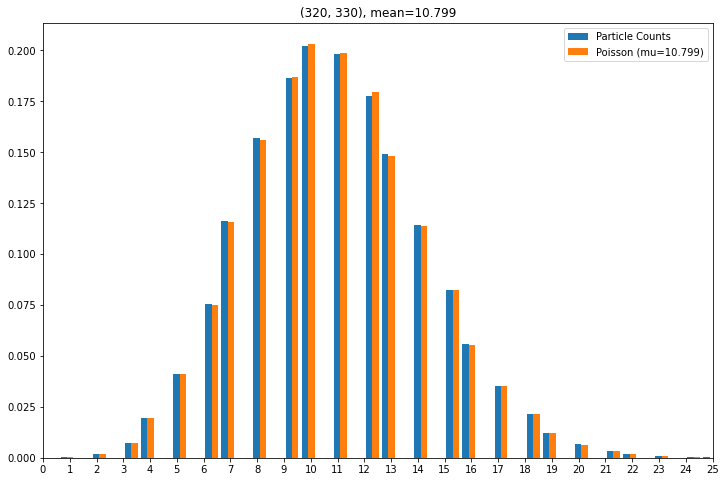

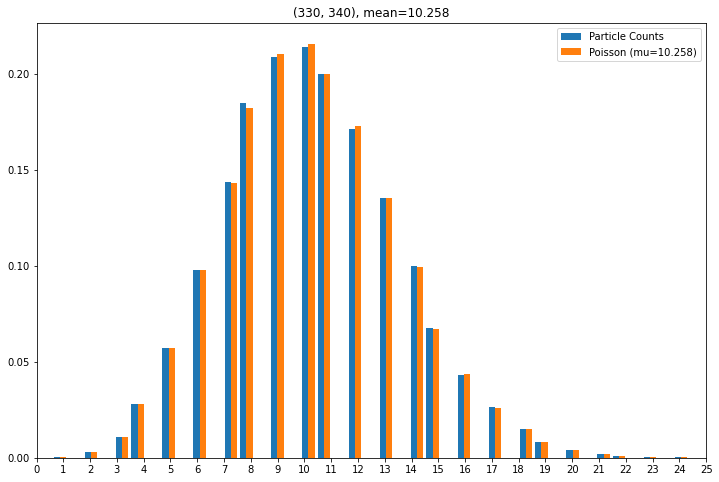

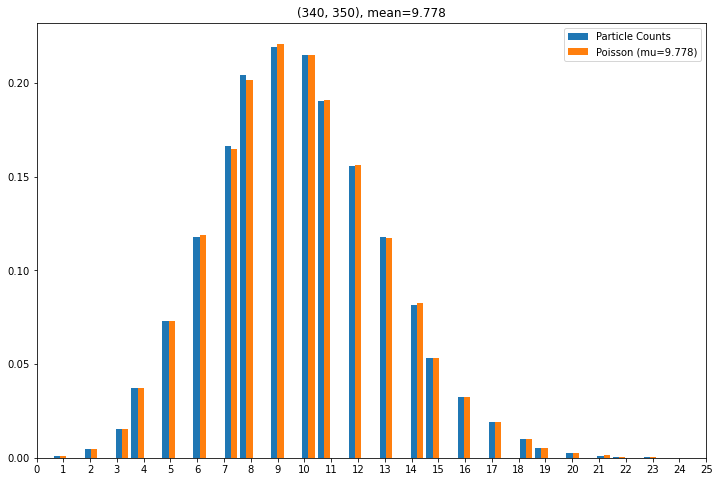

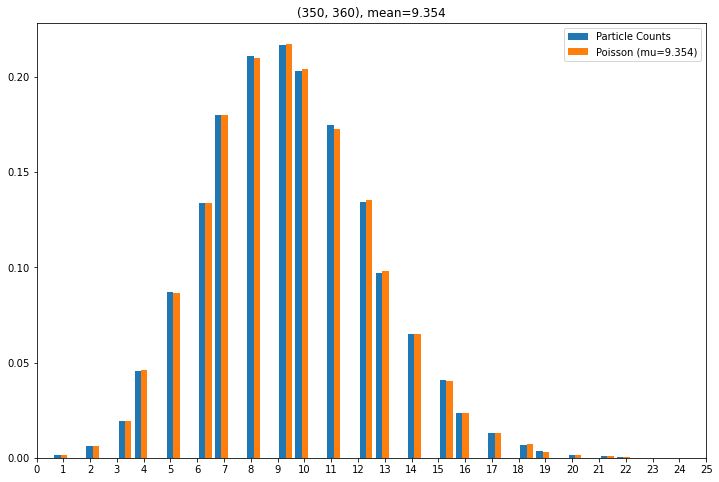

In [103]:
scan = np.arange(0,370,10)
minmax_range = [(scan[i],scan[i+1]) for i in range(scan.shape[0]-1)]
mean_list=[]
for minmax in minmax_range:
    _,mean = comp_p(data,minmax)
    mean_list.append(mean)

I split the longitude into 36 segments with 10 as the step and find that each segment follows Poisson distribution but with different mean value. Not let's find the pattern of the mean value.

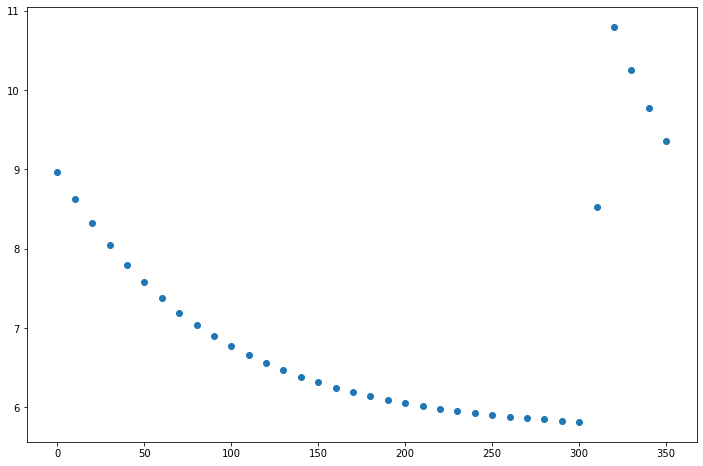

In [105]:
fig,ax=plt.subplots(1,1)
ax.scatter(scan[:-1],mean_list)

It seems that the breakpoint is at 310, let's rearrange the x-axis so that 310-360 is connected with 0-300

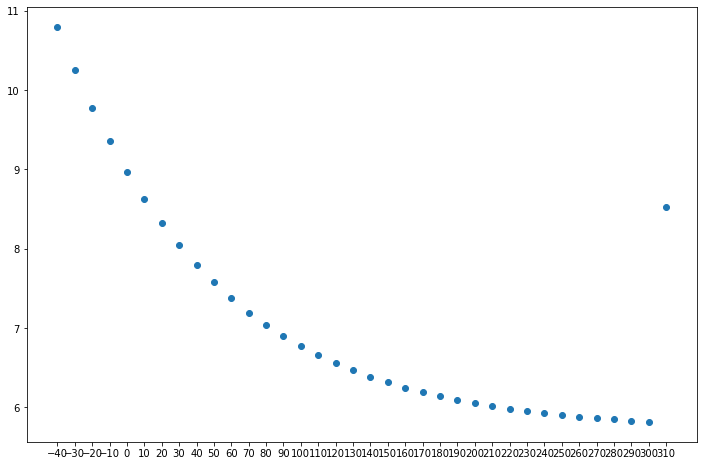

In [115]:
fig,ax=plt.subplots(1,1)
x=np.arange(-40,320,10)
y=np.roll(mean_list,4)
ax.scatter(x,y)
ax.set_xticks(np.arange(-40,320,10))
plt.show()

It seems the pattern follows polynomial functions. Let's try.

            3             2
-2.155e-07 x + 0.0001459 x - 0.03532 x + 9.026


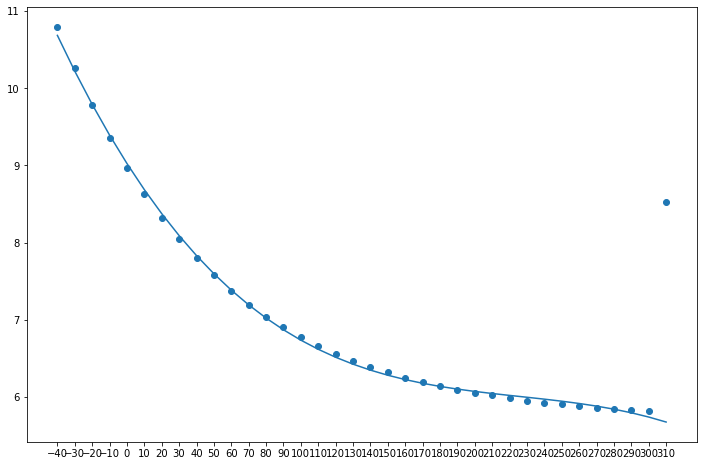

In [129]:
parameter = np.polyfit(x[:-1], y[:-1], 3)
p = np.poly1d(parameter,variable='x')
print(p)

fig,ax=plt.subplots(1,1)
x=np.arange(-40,320,10)
y=np.roll(mean_list,4)
ax.scatter(x,y)
ax.plot(x,p(x))
ax.set_xticks(np.arange(-40,320,10))
plt.show()

In conclusion, the background is a mixture of Poisson distribution with different mean value. The mean value follows cubed function: -2.155e-07 x^3 + 0.0001459 x^2 - 0.03532 x + 9.026.